<a href="https://colab.research.google.com/github/Uttamkumar-hub/greenhousegasemmison/blob/main/greenhousegasemmison2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [ ]:
# --- 1. Load and Combine Sheets ---
file_path = "/content/drive/MyDrive/SupplyChainEmissionFactorsforUSIndustriesCommodities2.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)

df_list = []
for sheet_name, sheet_df in all_sheets.items():
    if "Summary_Industry" in sheet_name:
        year = int(sheet_name.split("_")[0])
        sheet_df['Year'] = year
        df_list.append(sheet_df)

df = pd.concat(df_list, ignore_index=True)
df.columns = df.columns.str.strip().str.replace('\u200b', '', regex=False)


In [ ]:
# --- 2. Rename and Clean ---
df.rename(columns={
    'Industry Name': 'Industry',
    'Supply Chain Emission Factors with Margins': 'Total Emissions',
    'Supply Chain Emission Factors without Margins': 'Emission (No Margin)'
}, inplace=True)

df_cleaned = df.dropna(subset=['Total Emissions', 'Emission (No Margin)']).drop_duplicates()
df_cleaned['Total Emissions'] = pd.to_numeric(df_cleaned['Total Emissions'], errors='coerce')
df_cleaned['Emission (No Margin)'] = pd.to_numeric(df_cleaned['Emission (No Margin)'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Total Emissions', 'Emission (No Margin)'])
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('^Unnamed')]



/tmp/ipython-input-2976293624.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='Total Emissions', y='Industry', palette='mako')


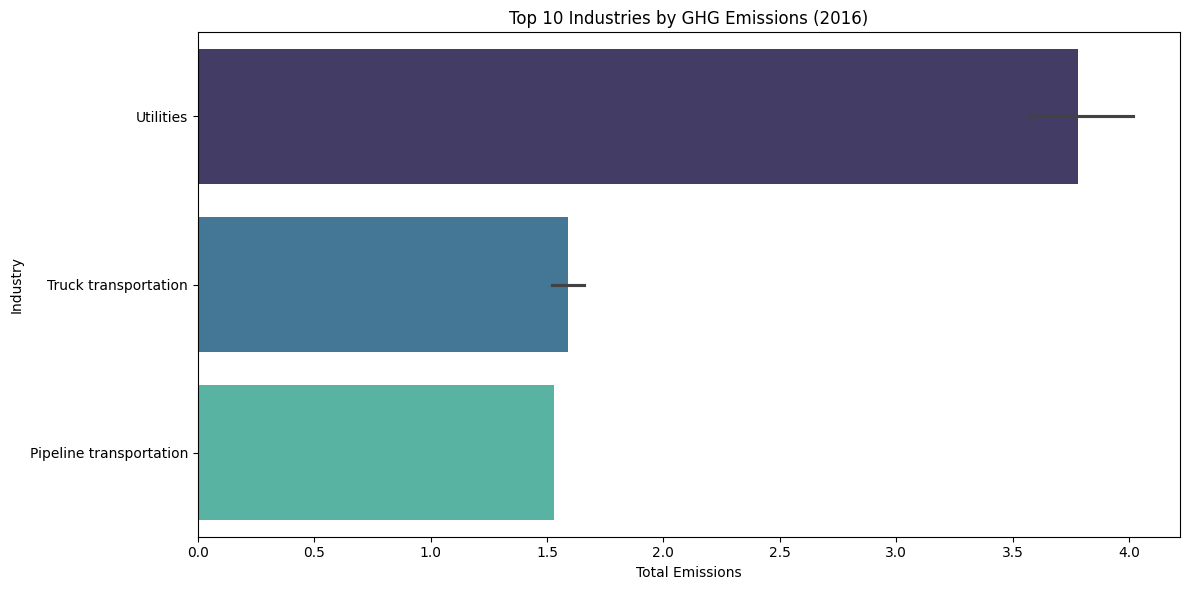

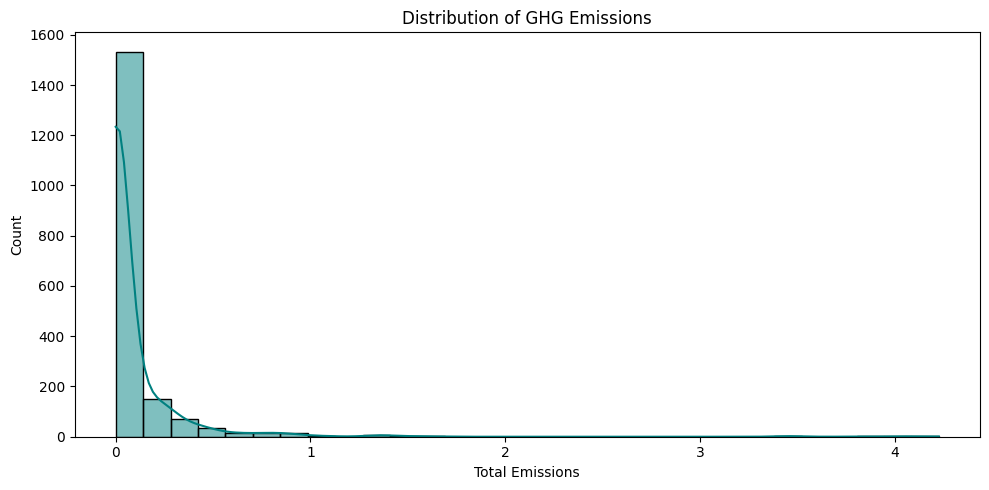

In [ ]:
# --- 3. Visualization ---
top_10 = df_cleaned.sort_values(by='Total Emissions', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, x='Total Emissions', y='Industry', palette='mako')
plt.title('Top 10 Industries by GHG Emissions (2016)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['Total Emissions'], bins=30, kde=True, color='teal')
plt.title('Distribution of GHG Emissions')
plt.tight_layout()
plt.show()


In [ ]:
# --- 4. Feature Engineering ---
X = df_cleaned[['Year'] + [col for col in df_cleaned.select_dtypes(include=[np.number]).columns if col not in ['Emission (No Margin)']]]
y = df_cleaned['Emission (No Margin)']

trained_features = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# --- 5. Train Models ---
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# --- 6. Evaluate Function ---
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R²: {r2_score(y_test, y_pred):.4f}\n")

evaluate_model("Linear Regression", lr_model, X_test, y_test)
evaluate_model("Decision Tree", dt_model, X_test, y_test)
evaluate_model("Random Forest", rf_model, X_test, y_test)


--- Linear Regression ---
MAE: 0.0001
RMSE: 0.0002
R²: 1.0000

--- Decision Tree ---
MAE: 0.0015
RMSE: 0.0063
R²: 0.9993

--- Random Forest ---
MAE: 0.0018
RMSE: 0.0090
R²: 0.9986



In [ ]:
# --- 7. Hyperparameter Tuning ---
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters for Random Forest:", grid_search.best_params_)
evaluate_model("Tuned Random Forest", best_rf, X_test, y_test)



Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
--- Tuned Random Forest ---
MAE: 0.0018
RMSE: 0.0087
R²: 0.9987



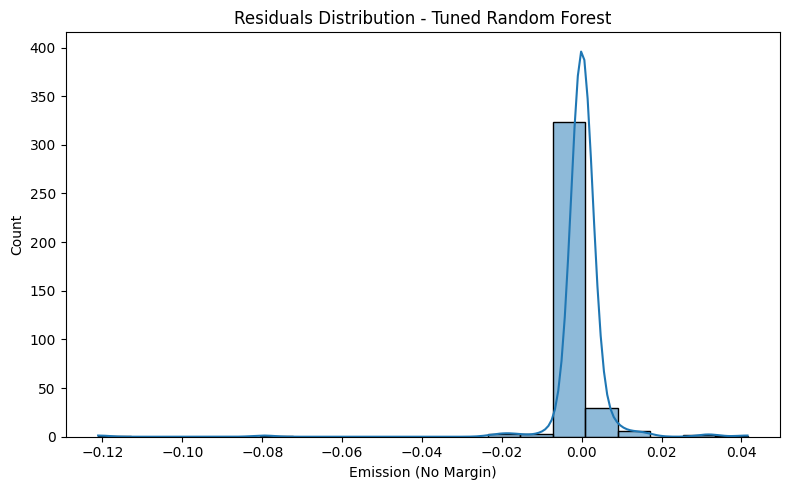

In [ ]:
# --- 8. Residuals ---
y_pred_rf = best_rf.predict(X_test)
residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=20)
plt.title("Residuals Distribution - Tuned Random Forest")
plt.tight_layout()
plt.show()


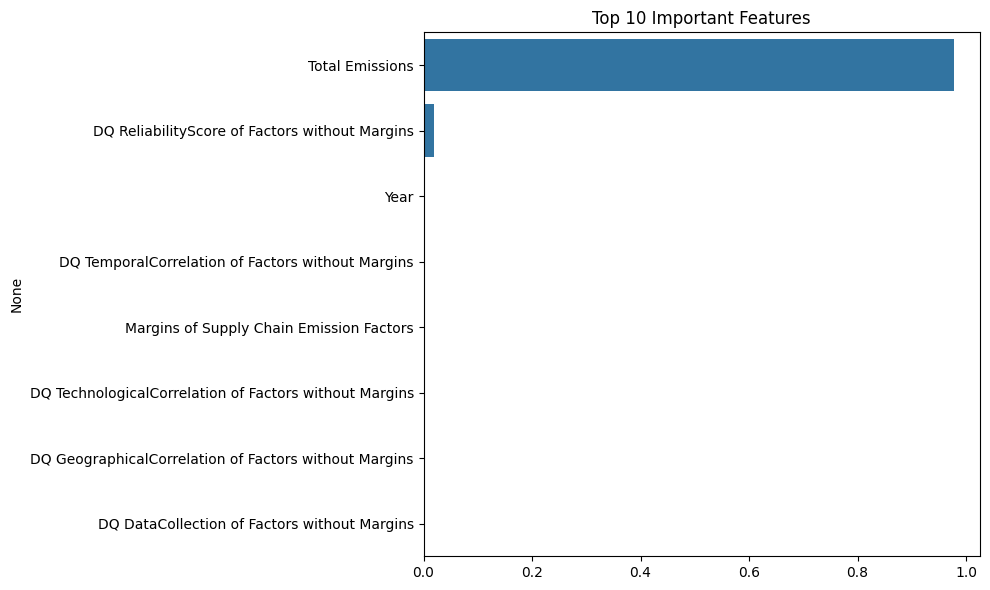

In [ ]:
# --- 9. Feature Importance ---
importances = pd.Series(best_rf.feature_importances_, index=trained_features)
top_features = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values[:10], y=top_features.index[:10])
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()


In [ ]:
# --- 10. Save Model ---
joblib.dump(best_rf, "best_rf_model.joblib")


['best_rf_model.joblib']


📊 Model Comparison:
                  Model       MAE      RMSE        R²
0    Linear Regression  0.000059  0.000220  0.999999
1        Decision Tree  0.001542  0.006268  0.999337
2        Random Forest  0.001803  0.008980  0.998640
3  Tuned Random Forest  0.001811  0.008744  0.998711


/tmp/ipython-input-1988124225.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_r')
/tmp/ipython-input-1988124225.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='RMSE', palette='Greens_r')
/tmp/ipython-input-1988124225.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R²', palette='Purples_r')


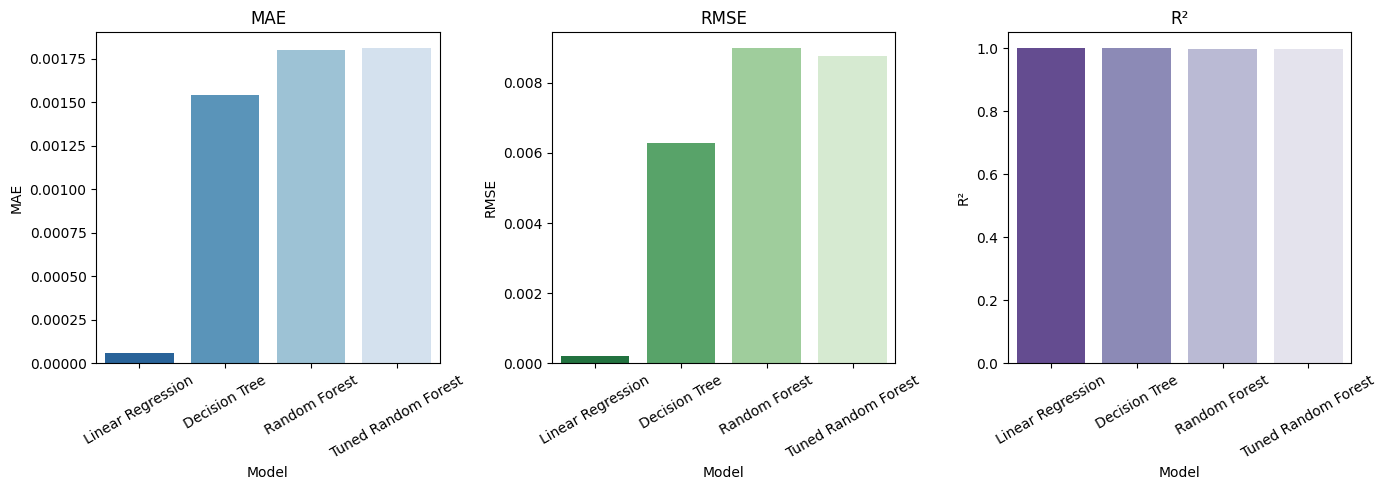

In [ ]:
# --- 11. Model Comparison ---
models = {
    "Linear Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "Tuned Random Forest": best_rf
}

metrics = {'Model': [], 'MAE': [], 'RMSE': [], 'R²': []}
for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics['Model'].append(name)
    metrics['MAE'].append(mean_absolute_error(y_test, y_pred))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    metrics['R²'].append(r2_score(y_test, y_pred))

metrics_df = pd.DataFrame(metrics)
print("\n📊 Model Comparison:\n", metrics_df)

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_r')
plt.xticks(rotation=30)
plt.title("MAE")

plt.subplot(1, 3, 2)
sns.barplot(data=metrics_df, x='Model', y='RMSE', palette='Greens_r')
plt.xticks(rotation=30)
plt.title("RMSE")

plt.subplot(1, 3, 3)
sns.barplot(data=metrics_df, x='Model', y='R²', palette='Purples_r')
plt.xticks(rotation=30)
plt.title("R²")

plt.tight_layout()
plt.show()



In [ ]:
# --- 12. Future Prediction ---
model = joblib.load("best_rf_model.joblib")
sample_input = df_cleaned[df_cleaned['Year'] == df_cleaned['Year'].max()].copy()
sample_input['Year'] += 1
sample_input = sample_input[trained_features]  # Ensure matching features
future_emissions = model.predict(sample_input)

# Combine with industry names for reference
if 'Industry' in df_cleaned.columns:
    sample_input['Predicted Emissions (No Margin)'] = future_emissions
    sample_input['Industry'] = df_cleaned[df_cleaned['Year'] == df_cleaned['Year'].max()]['Industry'].values
    print(sample_input[['Industry', 'Predicted Emissions (No Margin)']].head(10))
else:
    print("Predicted Emissions:", future_emissions[:10])

                                    Industry  Predicted Emissions (No Margin)
0                                      Farms                         0.473873
1                                      Farms                         0.024973
2                                      Farms                         0.002000
3                                      Farms                         0.004000
4  Forestry, fishing, and related activities                         0.177487
5  Forestry, fishing, and related activities                         0.001000
6  Forestry, fishing, and related activities                         0.000000
7  Forestry, fishing, and related activities                         0.002000
8                     Oil and gas extraction                         0.519293
9                     Oil and gas extraction                         0.028468


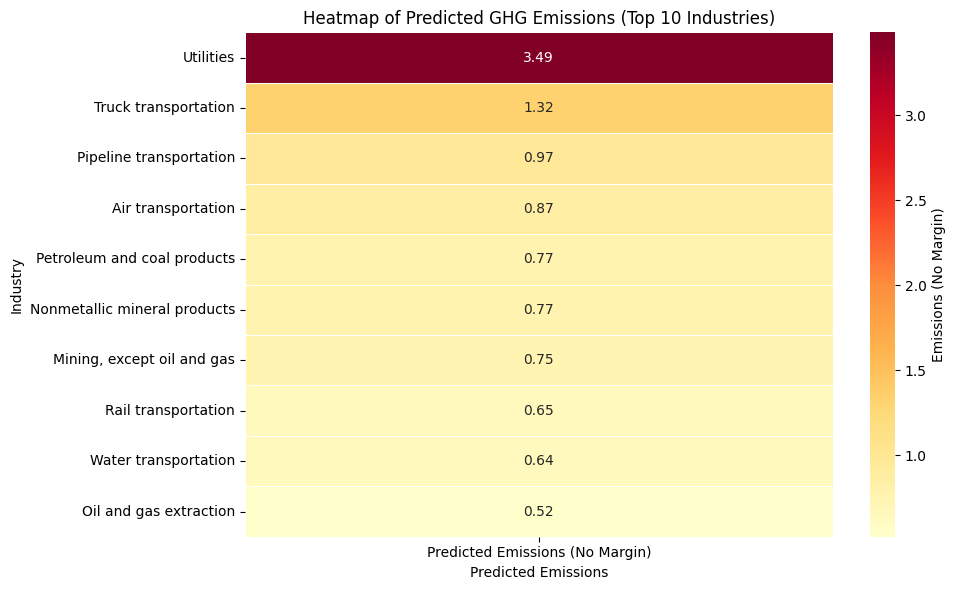

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get top 10 predicted industries by emissions
top_pred = sample_input.sort_values(by='Predicted Emissions (No Margin)', ascending=False).head(10)

# Create a DataFrame suitable for heatmap
heatmap_data = top_pred[['Industry', 'Predicted Emissions (No Margin)']]
heatmap_data = heatmap_data.set_index('Industry')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Emissions (No Margin)'})
plt.title("Heatmap of Predicted GHG Emissions (Top 10 Industries)")
plt.ylabel("Industry")
plt.xlabel("Predicted Emissions")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1345095752.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pred, x='Predicted Emissions (No Margin)', y='Industry', palette='crest')


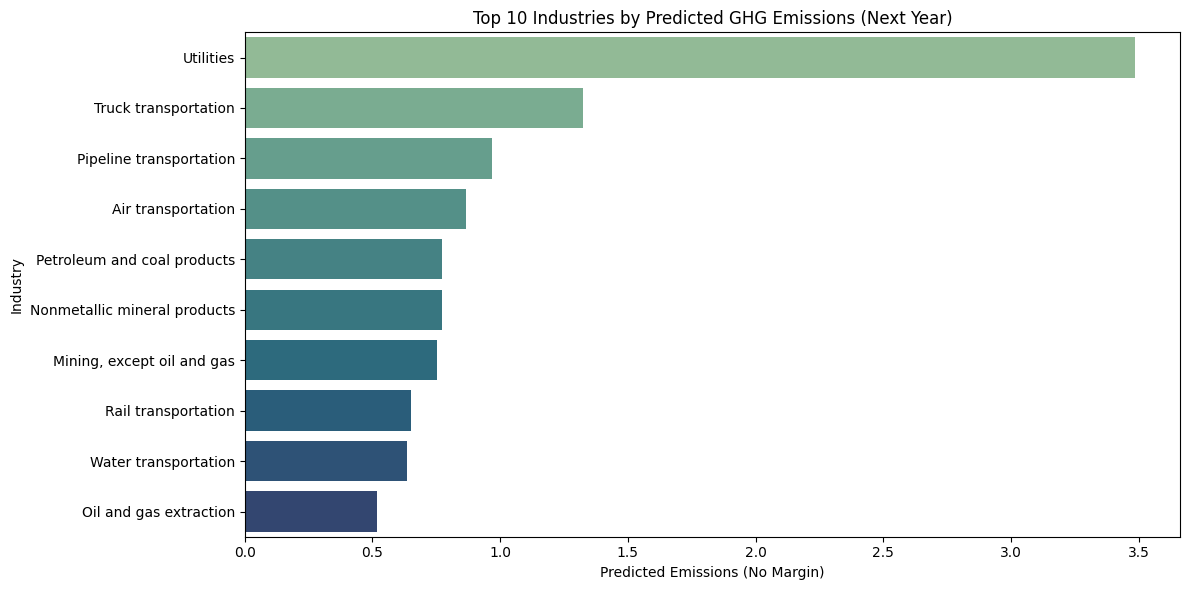

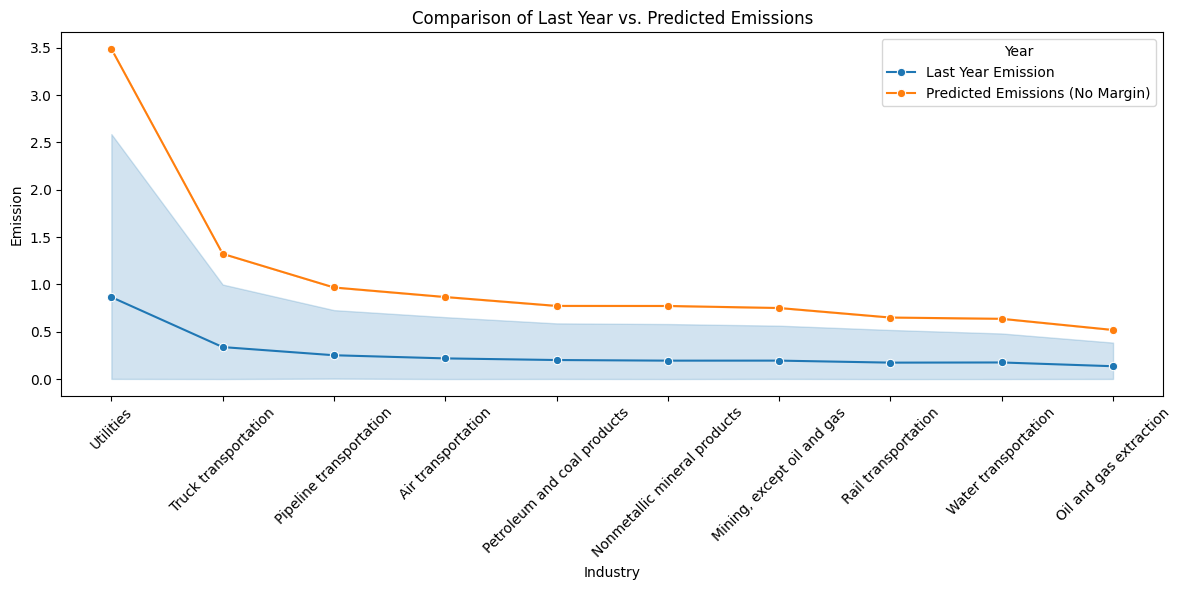

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort predictions to highlight top industries
top_pred = sample_input.sort_values(by='Predicted Emissions (No Margin)', ascending=False).head(10)

# 📊 Barplot: Top 10 Industries by Predicted Emissions (Next Year)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_pred, x='Predicted Emissions (No Margin)', y='Industry', palette='crest')
plt.title("Top 10 Industries by Predicted GHG Emissions (Next Year)")
plt.xlabel("Predicted Emissions (No Margin)")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

# 📈 Lineplot: Emission Trends (Last Year vs. Predicted)
historical_year = df_cleaned['Year'].max()
historical_data = df_cleaned[df_cleaned['Year'] == historical_year][['Industry', 'Emission (No Margin)']]
historical_data = historical_data.rename(columns={'Emission (No Margin)': 'Last Year Emission'})
comparison_df = top_pred[['Industry', 'Predicted Emissions (No Margin)']].merge(
    historical_data, on='Industry', how='left'
)

# Melt for lineplot
melted = comparison_df.melt(id_vars='Industry', value_vars=['Last Year Emission', 'Predicted Emissions (No Margin)'],
                            var_name='Year', value_name='Emission')

plt.figure(figsize=(12, 6))
sns.lineplot(data=melted, x='Industry', y='Emission', hue='Year', marker='o')
plt.xticks(rotation=45)
plt.title("Comparison of Last Year vs. Predicted Emissions")
plt.tight_layout()
plt.show()
